# Generating input data for urbs <a id='start'></a>
This notebook was written by Leonhard Odersky and Magdalena Dorfner. This notebook is licensed under the [GNU General Public License v3.0](https://www.gnu.org/licenses/gpl-3.0.en.html)

In this notebook the pre-processing for data in urbs is done. This includes retrieving, editing and adapting data from different sources. 

The notebook can be split in the following parts:
* General [Input](#input)
* [Aggregation](#aggregation) of
    * [power plant capacities](#capacities),
    * [storage constraints](#storage),
    * the [transmission grid](#transmisson),
    
   
* generating [timeseries](#timeseries) for
    * the [demand](#demand),
    * [supply intermittent](#supim) modelling,
        

Each part is structured the same. Firstly, used packages are imported. Secondly, the input is defined. Thirdly, the data is edited. And in the end, the new generated dataframe is saved.

To run this notebook correctly, in each part the cells have to be executed in the right order.

***
***

# General Input<a id='input'></a>
Back to [beginning](#start).

#### <center>  This part has to be executed at the very beginning! </center> 

### Input
Packages and data, which is used in all parts, are loaded. Also, some global parameters are defined.

In [1]:
import os
import define
import time
import numpy as np
import pandas as pd
from datetime import datetime

# Define folders
folder_in = 'Input'
folder_out = 'Output'

# Define subfolders for different parts
agg_subfolder = 'Aggregation'
ts_subfolder = 'Timeseries'

# Define data types
dt_csv = '.csv'
dt_xlsx = '.xlsx'
dt_png = '.png'

# Importing list of Bavarian regions in German and in English
regions_de = define.regions_by_de
regions_en = define.regions_by_en

# Importing dict to translate state names to English
region_translation = define.regions_translation_de_en

# Deactivate warnings
import warnings
warnings.filterwarnings('ignore')

### Postcodes
To assign power plants to its region, a list of postcodes with the regions as index is created. For this purpose, data from [Statistisches Bundesamt](https://www.destatis.de/DE/ZahlenFakten/LaenderRegionen/Regionales/Gemeindeverzeichnis/Gemeindeverzeichnis.html) is used.

#### Read in
In case, the PLZ have already been saved once, they can be read in

In [2]:
plz_file_out = 'Bavarian post codes per region'
plz_path_out = os.path.join(folder_out, plz_file_out+dt_xlsx)

try:
    plz = pd.read_excel(plz_path_out, index_col=0)
except:
    print('PLZ not yet saved. Please run cell below!')

In [7]:
# Define input
plz_file_in = 'Postleitzahlen.xls'
plz_path_in = os.path.join(folder_in, plz_file_in)

# Read in postcodes and regions from file
# Used columns for plz:
# D: RB - bavarian region
# 7: Gemeindename- name of community
# N: Postleitzahl - post code of community
plz = pd.read_excel(plz_path_in,sheet_name='Onlineprodukt_Gemeinden_311215',
                    index_col=0, usecols=[3,7,13], skiprows=8705, skipfooter=3851,
                    names=['index', 'region', 'plz'])

# Saving regions names in rb_dict
rb_dict = {}
for lv in range(1,8):
    rb_dict.update({lv : plz.loc[lv,'region'].iloc[0]})

# Change index of plz to regions names
plz = plz.rename(index=rb_dict)
plz.drop('region', axis=1, inplace=True)
plz = plz.loc[plz.plz>0]
plz.head()

# Adapt plz dataframe
plz.sort_values(by='plz', kind='mergesort', inplace=True)
plz.reset_index(inplace=True)
plz.rename(columns={'index':'region'}, inplace=True)

# Create dataframe with missing postcodes
diff = int((plz.max().loc['plz']+100) - (plz.min().loc['plz']))+1
help_df = pd.concat([pd.DataFrame([plz.min().loc['plz']+i], 
                                  columns=['plz']) for i in range(diff)], 
                    ignore_index=True)

# Add new postcodes 
plz = pd.merge(help_df, plz, left_on='plz', right_on='plz', how='left')

# Assign regions to postcodes
plz.fillna(method='pad', inplace=True)
plz.set_index('region', inplace=True)

# Save plz data frame
plz_file_out = 'Bavarian post codes per region'
plz_path_out = os.path.join(folder_out, plz_file_out+dt_xlsx)
plz.to_excel(plz_path_out)

***
***


## Aggregation <a id='aggregation'></a> 
Back to [beginning](#start).

***

### Power Plant Capacities<a id='capacities'></a> 
Back to [beginning](#start).
    
In the following cells, an Excel File with the capacities for all Bavarian power plants subdivided by their states and types is generated. For this, data from the [Open Power System Data platform](https://data.open-power-system-data.org/) (OPSD) is used (primary data from various sources, for a complete list see URL). It is read in, edited and saved to an excel file.


#### Input
All necessary data is read in from the OPSD files.

In [3]:
# Define input
cap_conv_file = 'conventional_power_plants_DE'
cap_ren_file = 'renewable_power_plants_DE'
year = '2015'

cap_conv_path = os.path.join(folder_in, agg_subfolder, 
                             cap_conv_file+dt_csv)
cap_ren_path = os.path.join(folder_in, agg_subfolder, 
                            cap_ren_file+dt_csv)

# Define dict to rename energies
cap_aggregation = {
    'Hydro': 'Hydro plant',
    'Other': 'Other plant',
    'Bio': 'Biomass plant'}

In [4]:
# Read in data from conventional and renewable power plants

# Used columns for cap_conv_data:
# 0: id - identify each plant
# 6: postcode - post code
# 8: state - assign each plant to its state
# 10: capacity_net_bnetza - capacity of each plant
# 12: fuel - sort plants into different types
# 13: technology - sort plants into different types
# 16: commissioned - since when is it active
# 20: status - check if plant is still running
cap_conv_data = pd.read_csv(cap_conv_path, index_col=0, usecols=[0,6,8,10,12,13,16,20], parse_dates=[6])

# Used columns for cap_ren_data:
# 0: commissioning_date - since when is it active
# 3: energy_source_level_2 - sort plants into different types
# 5: technology - sort plants into different types
# 6: electrical_capacity - capacity of each plant
# 11: dso_id - check if plant is running
# 14: federal_state - assign each plant to its state
# 15: postcode - post code
cap_ren_data = pd.read_csv(cap_ren_path, usecols=[0,3,5,6,11,14,15], parse_dates=[0])

#### Editing
In the following two dataframes are created. In `cap_ren` the capacities of the renewable power plants of each region subdivided by types are collected. In `cap_conv` the capacitys of the conventional power plants of each region subdivided by types are collected. The data is filtered, assigned to their region and concatenate in one dataframe.

In [5]:
# Generating new dataframe renew_caps 
cap_ren = pd.DataFrame()

# Filter data for plants in Bavaria
cap_ren_data.federal_state.loc[cap_ren_data.federal_state == 'BY'] = 'Bayern'
cap_ren_data = cap_ren_data.loc[cap_ren_data.federal_state == 'Bayern']

# Edit postcodes in data
#cap_ren_data['postcode'] = cap_ren_data['postcode'].str.replace('XX', '99')
cap_ren_data['postcode'] = cap_ren_data['postcode'].replace('-','80000')
#cap_ren_data['postcode'] = cap_ren_data['postcode'].str.replace('8000080000','80000')
#cap_ren_data = cap_ren_data[cap_ren_data.postcode.notnull()]
cap_ren_data.postcode = cap_ren_data.postcode.astype(np.int32)

# Add region column 
cap_ren_data['region'] = np.nan

# Assign renewable power plants to region by their postcode
# this can take long to run
for lvplz in plz.plz.values:
    region = plz[plz.plz == lvplz].index[0]
    cap_ren_data.loc[cap_ren_data.postcode==lvplz,'region'] = region      
        
# Filter for active power plants
for lvfuel in set(cap_ren_data.energy_source_level_2.values):
    helpdf = cap_ren_data.loc[(cap_ren_data.energy_source_level_2 == lvfuel) 
                              & (cap_ren_data.dso_id.fillna(0) != 0)
                              & (cap_ren_data.commissioning_date <= year)]
    
    # Sum capacity per region for each fuel type 
    for lv in set(helpdf.region.values):
        #print (lv)
        help_sum = helpdf.loc[helpdf.region == lv].electrical_capacity.sum()
        cap_ren.loc[lv, lvfuel+' plant']= help_sum

cap_ren.fillna(0, inplace=True)
cap_ren.sort_index()

,Geothermal plant,Hydro plant,Bioenergy plant,Wind plant,Solar plant
Mittelfranken,0.000,17.89027,220.78039,318.01242,1123.99034
Niederbayern,0.000,96.79845,190.62420,12.95639,2507.65419
Oberbayern,25.415,171.77146,363.40806,111.03892,2294.76056
Oberfranken,0.000,33.62421,100.02390,345.89048,748.10949
Oberpfalz,0.000,37.97706,192.19846,212.61475,1175.47840
Schwaben,0.000,147.05272,294.03276,80.92103,2032.74368
Unterfranken,0.000,85.35200,99.15084,383.37365,1060.50563


In [6]:
# Generating new dataframe conv_caps 
cap_conv = pd.DataFrame()

# Filter for plants in Bavaria
cap_conv_bav = cap_conv_data.loc[cap_conv_data.state == 'Bayern']
cap_conv_bav = cap_conv_bav[cap_conv_bav.postcode.notnull()]
cap_conv_bav.postcode = cap_conv_bav.postcode.astype(np.int32)
                                
# Add regions column                                
cap_conv_bav['region'] = np.nan

# Assign conventional power plants to region by their postcode
for (lvid,lvplz) in cap_conv_bav.postcode.iteritems():
    if lvplz in plz.values:
        region = plz[plz.plz == lvplz].index[0]
        cap_conv_bav.loc[lvid,'region'] = region

# Filter for active power plants
cap_conv_running = cap_conv_bav.loc[ (cap_conv_bav.status=='operating') 
                                    | (cap_conv_bav.status == 'reserve')
                                    & (cap_conv_bav.commissioned <= year)]

# Create tuple with technology and fuel type
cap_conv_tecfuel = set(tuple(map(tuple,cap_conv_running.loc[:, ['technology', 'fuel']].values)))

# Run for each technoloy and fuel type tuple
for (lvtec,lvfuel) in cap_conv_tecfuel:
    helpdf = cap_conv_running.loc[(cap_conv_running.fuel == lvfuel)]
    
    # Run for each state
    for lv in set(helpdf.region.values):

        # Split fuel type 'Natural gas' in different technologies
        if lvfuel == 'Natural gas':
            help_sum = helpdf.loc[helpdf.technology == 'Combined cycle'].loc[
                helpdf.region == lv].capacity_net_bnetza.sum()
            cap_conv.loc[lv, 'CC plant']= help_sum
            helpdf = helpdf.loc[helpdf.technology != 'Combined cycle']
        
        # Split fuel type 'Hydro' in different technologies
        elif lvfuel == 'Hydro':
            help_sum = helpdf.loc[helpdf.technology == 'Pumped storage'].loc[
                helpdf.region == lv].capacity_net_bnetza.sum()
            cap_conv.loc[lv, 'Pumped storage']= help_sum
            helpdf = helpdf.loc[helpdf.technology != 'Pumped storage']
            
        # Sum capacities for each fuel type
        help_sum = helpdf.loc[helpdf.region == lv].capacity_net_bnetza.sum()
        cap_conv.loc[lv, lvfuel+' plant']= help_sum
        helpdf = cap_conv_running.loc[(cap_conv_running.fuel == lvfuel)]
        

cap_conv.fillna(0, inplace=True)
cap_conv.drop(np.nan, inplace=True)
cap_conv.sort_index()   

,Waste plant,Pumped storage,Hydro plant,Hard coal plant,CC plant,Natural gas plant,Nuclear plant,Oil plant,Other fuels plant,Biomass and biogas plant
Mittelfranken,18.0,0.0,0.0,17.4,1001.3,18.60,0.0,0.0,0.0,0.0
Niederbayern,0.0,0.0,430.9,0.0,118.5,16.00,1410.0,0.0,0.0,0.0
Oberbayern,87.0,92.0,876.1,804.7,2178.9,349.74,0.0,1325.8,6.0,43.2
Oberpfalz,54.0,127.0,30.1,0.0,0.0,13.30,0.0,0.0,0.0,15.6
Schwaben,10.0,0.0,163.0,0.0,0.0,51.10,1288.0,57.3,0.0,0.0
Unterfranken,45.1,164.0,0.0,24.8,269.0,57.00,0.0,0.5,0.0,15.9


In [10]:
# Concatenate both data frames
cap_plants = pd.concat([cap_ren, cap_conv], axis=1, sort=True)

# Rename fuel types
for key in cap_aggregation.keys():
    col_list = [col for col in cap_plants.columns if key in col]
    help_sum = cap_plants[list(set(col_list))].sum(axis=1)
    cap_plants.drop(col_list, axis=1, inplace=True)
    cap_plants[cap_aggregation[key]] = help_sum

cap_plants = cap_plants.fillna(0).sort_index(axis=1)
cap_plants = cap_plants.rename({'AWZ':'Offshore'})

# Adding slack powerplants and curtailment
cap_slack = pd.DataFrame(index=cap_plants.index, 
                         columns=['Slack powerplant', 'Curtailment'], 
                         data=999999)
cap_lignite = pd.DataFrame(index=cap_plants.index, 
                         columns=['Lignite'], 
                         data=0)
cap_plants = pd.concat([cap_plants, cap_slack, cap_lignite], axis=1, sort=True)

# Rename columns to english region names
cap_plants = cap_plants.rename(index=region_translation)

# Sort columns and rows
cap_plants.sort_index(axis=0, inplace=True)
cap_plants.sort_index(axis=1, inplace=True)

cap_plants.rename(columns={'Solar plant': 'Photovoltaics', 'Wind plant': 'Wind turbine'}, inplace=True)
cap_plants.head(5)

,Biomass plant,CC plant,Curtailment,Geothermal plant,Hard coal plant,Hydro plant,Lignite,Natural gas plant,Nuclear plant,Oil plant,Other plant,Pumped storage,Slack powerplant,Photovoltaics,Waste plant,Wind turbine
Lower Bavaria,190.62420,118.5,999999,0.000,0.0,527.69845,0,16.00,1410.0,0.0,0.0,0.0,999999,2507.65419,0.0,12.95639
Lower Franconia,115.05084,269.0,999999,0.000,24.8,85.35200,0,57.00,0.0,0.5,0.0,164.0,999999,1060.50563,45.1,383.37365
Middle Franconia,220.78039,1001.3,999999,0.000,17.4,17.89027,0,18.60,0.0,0.0,0.0,0.0,999999,1123.99034,18.0,318.01242
Swabia,294.03276,0.0,999999,0.000,0.0,310.05272,0,51.10,1288.0,57.3,0.0,0.0,999999,2032.74368,10.0,80.92103
Upper Bavaria,406.60806,2178.9,999999,25.415,804.7,1047.87146,0,349.74,0.0,1325.8,6.0,92.0,999999,2294.76056,87.0,111.03892


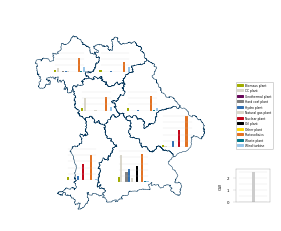

In [11]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition
%matplotlib inline

# Read in shape of Germany from GADM data
cap_subfolder_shapes = 'Shapes'
cap_subfolder_vis = 'Visualization'
cap_file_shape = 'bayern.shp'
cap_path_shape = os.path.join(folder_in, cap_subfolder_vis, cap_subfolder_shapes, cap_file_shape)
cap_shape_by = list(shpreader.Reader(cap_path_shape).geometries())

# Import colors
tumdarkblue = define.tumdarkblue
tumblue = define.tumblue
tumwhite = define.tumwhite

cmap = [define.tumgreen, define.tumivory, define.tumviolet,
        define.tumgrey, define.tumblue, define.tumivory, define.tumred,
        define.tumblack, define.tumbrightyellow, define.tumorange, 
        define.tumturquois, define.tumlightblue]

# Define output
data_typ_png = '.png'
cap_file_out_plot = 'bavaria-caps'
cap_path_out_plot = os.path.join(folder_out, cap_subfolder_vis, cap_file_out_plot+dt_png)

# Create figure for capacity plot
cap_fig_raw = plt.figure()

# Generate shape of Bavaria with regions
ax = plt.axes(projection=ccrs.EuroPP(), frameon=False)
ax.add_geometries(cap_shape_by, ccrs.PlateCarree(),
              edgecolor=tumdarkblue, facecolor=tumwhite, linewidth=.5)
ax.set_extent([8.2, 14.5, 47, 51], ccrs.PlateCarree())
    
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)

for state in cap_plants.index:
    ip = InsetPosition(ax, define.cap_positions_en[state])
    axin = inset_axes(ax,width=1,height=1)
    axin.set_axes_locator(ip)
    ix_height = list(cap_plants.loc[state].drop(['Lignite', 'Curtailment', 'Slack powerplant', 'Pumped storage']))
    
    axin.bar(np.arange(12),height=ix_height, tick_label='', color=cmap)
    axin.set_ylim([0,2600])
    axin.axis('off')
    for rvv in np.arange(0,round(max(ix_height)/1000)+1, 0.5):
        axin.plot(np.arange(12), np.full(shape=12,fill_value=rvv*1000), color=define.tumlightgrey, linewidth=.2)
        
ip = InsetPosition(ax, [1.01, 0.1, 0.15, 0.15])
axin = inset_axes(ax,width=1,height=1)
axin.set_axes_locator(ip)
ix_height = cap_plants.drop(['Lignite', 'Curtailment', 'Slack powerplant', 'Pumped storage'], axis=1).max().max()

axin.bar(np.arange(3),height=[0,ix_height/1000,0], tick_label='',width=0.2, color=define.tumlightgrey)
axin.set_ylim([0,2.7])
axin.set_ylabel('GW', fontsize=4)
axin.set_yticks(np.arange(0,3))
axin.set_yticklabels(np.arange(0,3), fontsize=4)
axin.yaxis.set_tick_params(width=.2, color=define.tumgrey)
for rvv in np.arange(0,int(ix_height/1000)+1, 0.5):
    axin.plot(np.arange(3), np.full(shape=3,fill_value=rvv), color=define.tumlightgrey, linewidth=.2)
    
plt.setp(axin.spines.values(), linewidth=.3, color=define.tumgrey)
axin.xaxis.set_ticks_position('none') 

cap_entries = cap_plants.drop(['Lignite','Curtailment', 'Slack powerplant', 'Pumped storage'],axis=1).columns
cap_patches = []
for nentry in range(0,len(cap_entries)):
    cap_patches.append(mpatches.Patch(color=cmap[nentry], label=cap_entries[nentry]))
ax.legend(handles=cap_patches, loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=3)

# Save plot to file
plt.gcf().savefig(cap_path_out_plot, bbox_inches='tight', dpi=1000)

#### Output

In [ ]:
# Define output
cap_plants_file = 'Bavarian Power Plant Capacities'
cap_plants_pump_file = 'Bavarian Storage Constraints OPSD'

# Write pumped storage to extra file
cap_pump_path_out = os.path.join(folder_out, agg_subfolder,
                                 cap_plants_pump_file+dt_xlsx)
try:
    cap_plants['Pumped storage'].T.to_excel(cap_pump_path_out)
    cap_plants.drop(['Pumped storage'], axis=1, inplace=True)
except:
    print('Dropped pumped storage already')
    
try:
    cap_plants.drop(['Lignite'], axis=1, inplace=True)
except:
    print('Lignite already dropped')

# Save remaining data to excel file
cap_path_out = os.path.join(folder_out, agg_subfolder, 
                            cap_plants_file+dt_xlsx)

# save to ready to copy version
cap_plants.stack().to_excel(cap_path_out)

# alternative: save as nicely formatted table
#cap_plants.T.to_excel(cap_path_out)

***

### Storage constraints <a id='storage'></a>
Back to [beginning](#start).

Here, the Bavarian storage constraints are constructed. Data is taken from [Bundesnetzagentur](https://www.bundesnetzagentur.de/SharedDocs/Downloads/DE/Sachgebiete/Energie/Unternehmen_Institutionen/Versorgungssicherheit/Erzeugungskapazitaeten/Kraftwerksliste/Kraftwerksliste_2015.html) \[License: [dl-de/by-2-0](https://www.govdata.de/dl-de/by-2-0)\]. It is read in, adapted and saved to an excel file.


#### Import

In [12]:
# Define input
sto_file_bnet_in = 'Kraftwerksliste_2015'
sto_path_bnet_in = os.path.join(folder_in, agg_subfolder,
                                sto_file_bnet_in+dt_xlsx)

# Read in data
# Used columns for sto_bnet:
# 3: PLZ - post code for each plant
# 6: Bundesland - state of each plant
# 10: Energieträger - production type
# 16: Netto-Nennleistung - production capacity
sto_bnet = pd.read_excel(sto_path_bnet_in, usecols=[3,6,10,16], skiprows=9)

#Filter data
sto_bnet = sto_bnet.loc[(sto_bnet.Bundesland=='Bayern')
                        &(sto_bnet.Energieträger=='Pumpspeicher')]
sto_bnet.drop(['Energieträger'], axis=1, inplace=True)
sto_bnet.rename(columns={'Netto-Nennleistung (elektrische Wirkleistung) in MW':'Kapazität',
                         'PLZ\n(Standort Kraftwerk)': 'PLZ',
                         'Bundesland': 'Region'},
                inplace=True)

# Assign storage to region by their postcode
# this can take long to run
for lvplz in plz.plz.values:
    region = plz[plz.plz == lvplz].index[0]
    sto_bnet.loc[sto_bnet.PLZ==lvplz,'Region'] = region 

# Sum data for each region
sto_bnet = sto_bnet.groupby('Region').sum()

# Rename columns to english region names
sto_bnet = sto_bnet.rename(index=region_translation)

# Define output
sto_file_bnet_out = 'Bavarian Storage Constraints BNetzA'
sto_path_bnet_out = os.path.join(folder_out, agg_subfolder, 
                                 sto_file_bnet_out+dt_xlsx)

# Save data to excel
sto_bnet.to_excel(sto_path_bnet_out)

sto_bnet.head()

,Kapazität
Region,
Middle Franconia,160.0
Upper Bavaria,92.0
Upper Palatinate,127.0
Lower Franconia,164.0


#### Storage plots

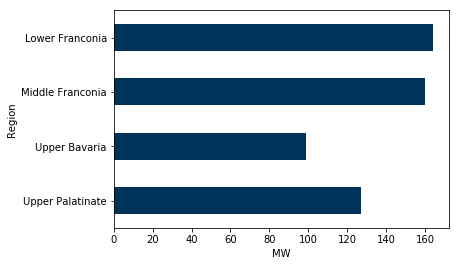

In [24]:
# standard plot
plt.figure()
sto_plot = sto_bnet.sort_index(ascending=False).plot(kind='barh', legend=False, color=define.tumdarkblue)

# Define output
data_typ_png = '.png'
sto_file_out_plot = 'bavaria-sto'
sto_path_out_plot = os.path.join(folder_out, cap_subfolder_vis, sto_file_out_plot+dt_png)
sto_plot.set_xlabel('MW')

# Save plot to file
plt.gcf().savefig(sto_path_out_plot, bbox_inches='tight', dpi=1000)

In [13]:
# comparison plot

vis_file_opsd_in = 'Bavarian Storage Constraints OPSD'
vis_path_opsd_in = os.path.join(folder_out, agg_subfolder,
                                vis_file_opsd_in+dt_xlsx)
sto_opsd = pd.read_excel(vis_path_opsd_in, index_col=0)

vis_file_bnet_in = 'Bavarian Storage Constraints BNetzA'
vis_path_bnet_in = os.path.join(folder_out, agg_subfolder, 
                                vis_file_bnet_in+dt_xlsx)
sto_bnet = pd.read_excel(vis_path_bnet_in, index_col=0)

# Create dataframe
sto_comp = pd.concat([sto_bnet, sto_opsd], axis=1, sort=True) 

# Adapt dataframe
sto_comp.rename(columns={'Pumped storage':'OPSD', 'Kapazität':'BNetzA'},
                inplace=True)
sto_comp.fillna(0, inplace=True)
sto_comp = sto_comp.astype(np.float64)

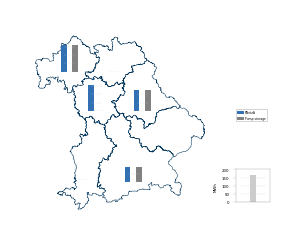

In [14]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition
%matplotlib inline

# Read in shape of Germany from GADM data
cap_subfolder_shapes = 'Shapes'
cap_subfolder_vis = 'Visualization'
cap_file_shape = 'bayern.shp'
cap_path_shape = os.path.join(folder_in, cap_subfolder_vis, cap_subfolder_shapes, cap_file_shape)
cap_shape_by = list(shpreader.Reader(cap_path_shape).geometries())

# Import colors
tumdarkblue = define.tumdarkblue
tumblue = define.tumblue
tumwhite = define.tumwhite
tumgrey = define.tumgrey

sto_cmap = [tumblue, tumgrey]

# Define output
data_typ_png = '.png'
cap_file_out_plot = 'bavaria-sto-comp'
cap_path_out_plot = os.path.join(folder_out, cap_subfolder_vis, cap_file_out_plot+dt_png)

# Create figure for capacity plot
cap_fig_raw = plt.figure()

# Generate shape of Bavaria with regions
ax = plt.axes(projection=ccrs.EuroPP(), frameon=False)
ax.add_geometries(cap_shape_by, ccrs.PlateCarree(),
              edgecolor=tumdarkblue, facecolor=tumwhite, linewidth=.5)
ax.set_extent([8.2, 14.5, 47, 51], ccrs.PlateCarree())
    
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)

for state in sto_comp.index:
    ip = InsetPosition(ax, define.cap_positions_en[state])
    axin = inset_axes(ax,width=1,height=1)
    axin.set_axes_locator(ip)
    ix_height = list(sto_comp.loc[state])
    
    axin.bar(np.arange(2),height=ix_height, width=0.5, tick_label='', color=sto_cmap)
    axin.set_ylim([0,200])
    axin.set_xlim([-1,2])
    axin.axis('off')
    for rvv in np.arange(0,round(max(ix_height))+1, 50):
        axin.plot(np.arange(2), np.full(shape=2,fill_value=rvv), color=define.tumlightgrey, linewidth=.2)
        
ip = InsetPosition(ax, [1.01, 0.1, 0.15, 0.15])
axin = inset_axes(ax,width=1,height=1)
axin.set_axes_locator(ip)
ix_height = sto_comp.max().max()

axin.bar(np.arange(3),height=[0,ix_height,0], tick_label='',width=0.5, color=define.tumlightgrey)
axin.set_ylim([0,2.7])
axin.set_ylabel('MWh', fontsize=4)
axin.set_yticks(np.arange(0,201, 50))
axin.set_yticklabels(np.arange(0,201,50), fontsize=4)
axin.yaxis.set_tick_params(width=.2, color=define.tumgrey)
for rvv in np.arange(0,int(ix_height)+1, 50):
    axin.plot(np.arange(3), np.full(shape=3,fill_value=rvv), color=define.tumlightgrey, linewidth=.2)
    
plt.setp(axin.spines.values(), linewidth=.3, color=define.tumgrey)
axin.xaxis.set_ticks_position('none') 

cap_entries = sto_comp.columns
cap_patches = []
for nentry in range(0,len(cap_entries)):
    cap_patches.append(mpatches.Patch(color=sto_cmap[nentry], label=cap_entries[nentry]))
ax.legend(handles=cap_patches, loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=3)

# Save plot to file
plt.gcf().savefig(cap_path_out_plot, bbox_inches='tight', dpi=1000)

***

### Transmission Grid Aggregation<a id='transmisson'></a>
Back to [beginning](#start).

Here, the Bavarian transmission grid based on data from [SciGrid](http://www.scigrid.de/pages/downloads.html) \[License: [Apache License, Version 2.0](http://www.apache.org/licenses/LICENSE-2.0)\] is aggregated. Additionally, links to surrounding states are included. As the raw data of SciGrid has some invalide notations, it should be checked before using. Especially the right amount of commi in each line should be checked.

This part can be separated into four subparts: collecting data, calculating phyiscal values, adpating data and visualizing the resulting net. The calculation algorithm is based on the Bachelor's thesis "Automatic transmission grid aggregation for Bavaria", supervised by Magdalena Dorfner at TUM. In each part a short introduction is given.

To run this part correctly run the cells from first to last.

#### Import

In [35]:
from geopy.geocoders import Nominatim
from urllib.request import Request
import geopy.distance
import re
import math
geo = Nominatim()

# Importing list of German states
states_de = define.states_de

#### Input
At first, the input files are defined. The raw data are read from csv-files to dataframes. It's split by the sources, due to their different structures.

In [36]:
# Read data from csv-files

# Define new data frames
tra_nodes = pd.DataFrame()
tra_lines = pd.DataFrame()

# Define special data type
tra_dt = '.csvdata'

# Read in nodes
tra_file_in_nodes = 'sci_vertices'
tra_path_in_nodes = os.path.join(folder_in, agg_subfolder, 
                                 tra_file_in_nodes+tra_dt)
# Used columns:
# 0: v_id - identify each node
# 1: lon - longitude of each node
# 2: lat - latitude of each node
help_df = pd.read_csv(tra_path_in_nodes, usecols=[0,1,2], index_col=0)
tra_nodes = pd.concat([tra_nodes,help_df])

#Read in lines
tra_file_in_lines = 'sci_links'
tra_path_in_lines = os.path.join(folder_in, agg_subfolder, 
                                 tra_file_in_lines+tra_dt)

help_df = pd.read_csv(tra_path_in_lines, index_col=[0,1,2])
tra_lines = pd.concat([tra_lines,help_df])

#### Requesting Geographical Data
Each node will be assigned to a state and a region. For this purpose the geograhpical location is sent to [OpenStreetMap](https://wiki.openstreetmap.org/wiki/Nominatim) and the address is recieved. This process takes quiet a long time. Because of that, it is checked in the first line, if already a file with addresses exists.
If not, the address for all nodes is retrieved. As the user gets banned from the server after too many request in a short time, some breaks are put in the algorithm. 

In [37]:
# Define subfolder for retrieved data
tra_subfolder_retr = 'Data retrieval'

# Construct address, region and state for each node
try:
    # If data is already existing, read data from file
    bla
    tra_file_in_nodes = 'KnotenSciGrid'
    tra_path_in_nodes = os.path.join(folder_in, agg_subfolder, 
                                     tra_subfolder_retr, tra_file_in_nodes+dt_xlsx)
    tra_nodes = pd.read_excel(tra_path_in_nodes, index_col=0)

except:
    # Add columns for address, region and state
    tra_nodes['address'] = np.nan
    tra_nodes['region'] = np.nan
    tra_nodes['state'] = np.nan
    tra_nodes = tra_nodes.groupby(tra_nodes.index).first()
    counter = 0
    counter2 = 0
    
    # Request address from nominatim for all nodes
    while counter < len(tra_nodes.index):
        lv = tra_nodes.index[counter]
        
        # 15 minutes break after 1000 requests
        if counter2 == 1000:
            print('Recieved first 1000 adresses. Sleeping for 15 minutes, to avoid getting banned. Startet sleeping: '
                  +str(datetime.now()))
            time.sleep(900)
            counter2 = 0
            
        # Get geodata from different sources
        lat, lon = tra_nodes.lat[lv], tra_nodes.lon[lv]
            
        # Try request address
        try:
            cord = geo.reverse('%s, %s' % (lat, lon), timeout=10)
            counter = counter+1
            counter2 = counter2+1
            
        # If request fails, wait one hour to overcome ban
        # and save already retrieved values to excel
        except:
            print('Nominatim Error 429: Too many requests! Have to wait one hour. Startet sleeping: '
                  +str(datetime.now()))
            tra_file_out_nodes = 'nodes_at_'+str(counter)
            tra_path_out_nodes = os.path.join(folder_in, agg_subfolder,
                                              tra_subfolder_retr, 
                                              tra_file_out_nodes+dt_xlsx)
            tra_nodes.to_excel(tra_path_out_nodes)
            time.sleep(3600)
            continue
            
        # Get address, region and state
        address = cord.address
        region = np.nan
        state = np.nan
        asplit = address.split(', ')
        
        #Get state for each node
        for st in states_de:
            if st in address:
                state = st
                break
            if 'EEZ' in address:
                state = 'Offshore'
                break
            elif st == 'Thüringen' and state!=st:
                state = 'Ausland'
        
        #Get region for each node, default region = state        
        region = state
        # Check if abbreviations in address
        if 'OB' in address:
            region = 'Oberbayern'
        elif 'Obb' in address:
            region = 'Oberbayern'
        elif 'NB' in address:
            region = 'Niederbayern'
        elif 'OPf' in address:
            region = 'Oberpfalz'
        # Check if region in address
        else:
            for rg in regions_de:
                if rg in address:
                    region = rg
                
        # Assign address, region and state to node
        tra_nodes.loc[lv, 'address'] = address
        tra_nodes.loc[lv, 'state'] = state
        tra_nodes.loc[lv, 'region'] = region

    # Save recieved addresses
    tra_file_out_nodes = 'KnotenSciGrid'
    tra_path_out_nodes = os.path.join(folder_in, agg_subfolder,
                                      tra_subfolder_retr, tra_file_out_nodes+dt_xlsx)
    tra_nodes.to_excel(tra_path_out_nodes)

tra_nodes.head(5)

,lon,lat,address,region,state
v_id,,,,,
1,9.522576,52.360409,"K 251, Seelze, Region Hannover, Niedersachsen,...",Niedersachsen,Niedersachsen
2,9.113210,52.543853,"Süllhof, Landesbergen, Samtgemeinde Mittelwese...",Niedersachsen,Niedersachsen
3,9.389745,52.026313,"Eigenbedarfsgebäude, Reherstraße, Emmerthal, K...",Niedersachsen,Niedersachsen
4,9.125266,52.538264,"Umspanwerk Landesbergen, In den Büschen, Hahne...",Niedersachsen,Niedersachsen
5,10.366275,52.284647,"Wahle, Landkreis Peine, Niedersachsen, 38159, ...",Niedersachsen,Niedersachsen


#### Editing
Each transmission line is connected to the address of their starting and ending node. As only the Bavarian net is considered, all lines, which starting or ending node has no Bavarian address, are neglected. In `tra_statelinks` all transmission lines, which connect two states, are collected.

After collecting all transmission lines connecting two states in the dataframe `tra_statelinks`, the parameters reactance per km (`x_ohmkm`), susceptance factor per kilometer (`c_nfkm`) and the length in meter (`length_m`) are added. For lines without those values, the mean value of the other lines normalized by length is set. 

In [38]:
# Filtering lines which start and end at a node with a state
tra_indices = tra_nodes.loc[tra_nodes.state==tra_nodes.state].index
help_lines = tra_lines.loc[((tra_lines.index.get_level_values('v_id_1').isin(tra_indices))) &
                           ((tra_lines.index.get_level_values('v_id_2').isin(tra_indices)))]

# Create additonal columns for calcualtion
help_index = pd.MultiIndex.from_tuples(help_lines.index.values, names=['id', 'v1', 'v2'])
help_df = pd.DataFrame(index=help_index, columns=['cap', 'reactance', 'shuntcap',
                                                  'susceptance', 'capfactor', 'sil',
                                                  'vin', 'vout', 'length'])

# Create dataframe with all links between nodes
tra_links = pd.concat([help_df, help_lines.loc[:, 'voltage': 'frequency']], axis=1)

# Save links to excel
tra_file_out_links = 'LinksSciGrid_Germany'
tra_path_out_links = os.path.join(folder_in, agg_subfolder, 
                                  tra_subfolder_retr, tra_file_out_links+dt_xlsx)
tra_links.to_excel(tra_path_out_links)

# Set region of nodes to index
for (lv1, lv2, lv3) in help_index.values:
    ind = (lv1, lv2, lv3)
    tra_links.vin.loc[ind] = tra_nodes.region[lv2]
    tra_links.vout.loc[ind] = tra_nodes.region[lv3]

# Finding all links between regions
tra_regionlinks = tra_links.loc[tra_links.vin!=tra_links.vout]

# Filter lower voltage lines
tra_regionlinks = tra_regionlinks.loc[(tra_regionlinks.voltage!=110000)]

# Assign values to new added columns of dataframe
tra_regionlinks.reactance = help_lines.loc[tra_regionlinks.index].x_ohmkm
tra_regionlinks.shuntcap = help_lines.loc[tra_regionlinks.index].c_nfkm
tra_regionlinks.length = help_lines.loc[tra_regionlinks.index].length_m

# List of possible voltages
tra_voltages = [220000, 300000, 380000, 400000, 450000]

# Scaling reactance and shuntcap to length to calculate mean values
tra_regionlinks.reactance.loc[tra_regionlinks.reactance.notnull()] = tra_regionlinks.reactance.loc[
    tra_regionlinks.reactance.notnull()]/tra_regionlinks.length
tra_regionlinks.shuntcap.loc[tra_regionlinks.shuntcap.notnull()] = tra_regionlinks.shuntcap.loc[
    tra_regionlinks.shuntcap.notnull()]/tra_regionlinks.length

# Set mean values instead of nan in reactance and shuntcap column
for vol in tra_voltages:  
    tra_regionlinks.reactance.loc[tra_regionlinks.reactance.isnull() 
                                 & (tra_regionlinks.voltage==vol)] = tra_regionlinks.loc[
        tra_regionlinks.reactance.notnull() & (tra_regionlinks.voltage==vol)].reactance.mean()
    tra_regionlinks.shuntcap.loc[tra_regionlinks.shuntcap.isnull() 
                                & (tra_regionlinks.voltage==vol)] = tra_regionlinks.loc[
        tra_regionlinks.shuntcap.notnull() & (tra_regionlinks.voltage==vol)].shuntcap.mean()

# Undo scaling of reactance and shuntcap to length
tra_regionlinks.reactance.loc[tra_regionlinks.reactance.notnull()] = tra_regionlinks.reactance.loc[
    tra_regionlinks.reactance.notnull()]*tra_regionlinks.length
tra_regionlinks.shuntcap.loc[tra_regionlinks.shuntcap.notnull()] = tra_regionlinks.shuntcap.loc[
    tra_regionlinks.shuntcap.notnull()]*tra_regionlinks.length

# Filter tra_regionslinks for nodes in Bavaria and close states
tra_regionlinks = tra_regionlinks[tra_regionlinks.vin.isin(regions_de) 
                                  | tra_regionlinks.vout.isin(regions_de)]
tra_regionlinks = tra_regionlinks[tra_regionlinks.vin != 'Ausland']
tra_regionlinks = tra_regionlinks[tra_regionlinks.vout != 'Ausland']

tra_regionlinks.head()

,,,cap,reactance,shuntcap,susceptance,capfactor,sil,vin,vout,length,voltage,cables,wires,frequency
id,v1,v2,,,,,,,,,,,,,
295,216,227,NaN,0.250000,13.700000,NaN,NaN,NaN,Baden-Württemberg,Schwaben,114977,380000,3.0,4.0,50.0
299,232,233,NaN,0.210435,7.477551,NaN,NaN,NaN,Schwaben,Baden-Württemberg,19768,220000,3.0,NaN,50.0
303,233,227,NaN,0.250000,13.700000,NaN,NaN,NaN,Baden-Württemberg,Schwaben,16623,380000,3.0,4.0,50.0
316,68,245,NaN,0.250000,13.700000,NaN,NaN,NaN,Hessen,Unterfranken,20594,380000,3.0,4.0,50.0
317,245,246,NaN,0.250000,13.700000,NaN,NaN,NaN,Unterfranken,Hessen,4449,380000,3.0,4.0,50.0


***
#### Calculation of physical value
The capacity of each line is calculated. The calculation algorithm is based on the Bachelor's thesis "Automatic transmission grid aggregation for Bavaria", supervised by Magdalena Dorfner at TUM.

For a better estimation of loadability $c$ the St-Clair-Curve is fitted by inspection. The recieved function is used to estimate $c$ for each line.

In [39]:
# Calculcate shunt susceptance
tra_regionlinks.susceptance = 2* math.pi* 50* tra_regionlinks.shuntcap / (10**3)

# Function to fill the values for the loadability c 
def cfactor(x):
    c = 5.8113 - 0.851647*math.log(x/1000)
    return c 

# Filling the values for the loadability c 
for lv in tra_regionlinks.index:
    tra_regionlinks.capfactor[lv] = cfactor(tra_regionlinks.loc[lv, 'length'])

# Calculate surge impedance loading (SIL)
tra_regionlinks.sil = (tra_regionlinks.voltage / (10**3))**2 * (tra_regionlinks.susceptance /
                                                      ((10**6) * tra_regionlinks.reactance)) ** (1/2)

# Calculates capacity
tra_regionlinks.cap = tra_regionlinks.sil * tra_regionlinks.capfactor

# Check for thermal limits
tra_thermal_limits = {220000: 400, 380000: 1800}
tra_regionlinks.cap.loc[(tra_regionlinks.cap > 
                        tra_regionlinks.voltage.map(tra_thermal_limits)* tra_regionlinks.cables / 3)
                       & (tra_regionlinks.length < 80000)] = tra_regionlinks.voltage.map(
                                                                tra_thermal_limits)

# Finished calculation
tra_regionlinks.head(5)

,,,cap,reactance,shuntcap,susceptance,capfactor,sil,vin,vout,length,voltage,cables,wires,frequency
id,v1,v2,,,,,,,,,,,,,
295,216,227,1060.77,0.250000,13.700000,4.303982,1.77046,599.145648,Baden-Württemberg,Schwaben,114977,380000,3.0,4.0,50.0
299,232,233,400,0.210435,7.477551,2.349142,3.26993,161.711658,Schwaben,Baden-Württemberg,19768,220000,3.0,NaN,50.0
303,233,227,1800,0.250000,13.700000,4.303982,3.4175,599.145648,Baden-Württemberg,Schwaben,16623,380000,3.0,4.0,50.0
316,68,245,1800,0.250000,13.700000,4.303982,3.23507,599.145648,Hessen,Unterfranken,20594,380000,3.0,4.0,50.0
317,245,246,1800,0.250000,13.700000,4.303982,4.54006,599.145648,Unterfranken,Hessen,4449,380000,3.0,4.0,50.0


#### Adapt data

All lines between the same states are collected in one connection. Additionally, a column for median length between states and investmens costs for new lines between these states is added. Specific cost for building new lines (investment costs) are assumed to be $2000\frac{€}{MW*km}$. Furthermore, specific cost for maintaining lines (fixed costs) are assumed to be $1.1\frac{€}{MW*km}$. Those values are taken from the bachelor's thesis "Technical, Economic and Ecological Analysis of Conventional and Innovative Power Transmission Technologies" of Kais Siala, which was written at TUM. Finally, the output structure is converted to the input file structure of urbs. 

In [40]:
# Exchange vin and vout in case of wrong order
help_bool = tra_regionlinks.vin > tra_regionlinks.vout
help_df = tra_regionlinks.vout.loc[help_bool]
tra_regionlinks.vout.loc[help_bool] = tra_regionlinks.vin.loc[help_bool]
tra_regionlinks.vin.loc[help_bool] = help_df
      
# Function for reducing statelinks to one for each state-pair
def aggregate_lines(df):
    lv = 0
    while lv < len(df)-1:
        # check for same in and output nodes
        if (df.iloc[lv,6] == df.iloc[lv+1,6]) & (df.iloc[lv,7] == df.iloc[lv+1,7]):
            # add capacities
            df.iloc[lv,0] = df.iloc[lv,0] + df.iloc[lv+1,0]
            df = df.drop(df.index[lv+1])
        else:
            lv +=1
            
    df_final = df
    return df_final

# Sort and aggreaget transmission lines
tra_regionlinks = tra_regionlinks.sort_values(['vin', 'vout'])
try:
    tra_regionlinks = aggregate_lines(tra_regionlinks.reset_index().loc[:, 'cap':'length'])
except:
    pass

# Read in coordinates of the geographical center of each region/state
tra_coordinates_de = define.coordinates_regions_states_by_de
tra_distances = pd.DataFrame(index=tra_coordinates_de, columns=tra_coordinates_de)

# Calculate median length between states
for key1 in tra_coordinates_de:
    for key2 in tra_coordinates_de:
        help_distance = geopy.distance.vincenty(tra_coordinates_de[key1], tra_coordinates_de[key2]).km
        tra_distances[key1][key2] = help_distance

# Set distance to length of lines
for st1 in tra_regionlinks['vin']:
    for st2 in tra_regionlinks['vout']:
        try:
            tra_regionlinks.length[(tra_regionlinks.vin == st1) 
                           & (tra_regionlinks.vout == st2)] = tra_distances[st1][st2]
        except:
            pass

# Include column for investment costs
tra_regionlinks['inv-cost'] = tra_regionlinks['length']*2000

# Include column for fix costs
tra_regionlinks['fix-cost'] = tra_regionlinks['length']*1.1

# Adapting to input file structure of urbs
tra_regionlinks = tra_regionlinks[['vin','vout','inv-cost','fix-cost','cap', 'length']]

# Rename regions to English names
tra_regionlinks.replace({'vin': region_translation, 'vout': region_translation}, inplace=True)

tra_regionlinks.head()

,vin,vout,inv-cost,fix-cost,cap,length
0,Baden-Württemberg,Swabia,226863.575618,124.774967,3260.77,113.431788
3,Baden-Württemberg,Lower Franconia,390539.438560,214.796691,2166.72,195.269719
5,Hesse,Lower Franconia,177825.067503,97.803787,6390.2,88.912534
10,Middle Franconia,Lower Bavaria,344521.167062,189.486642,349.366,172.260584
11,Middle Franconia,Upper Bavaria,338188.888315,186.003889,1128.32,169.094444


#### Output


In [41]:
# Define output
tra_file_out = 'Bavarian Transmission Grid'
tra_path_out = os.path.join(folder_out, agg_subfolder,
                            tra_file_out+dt_xlsx)

# Save file to excel
tra_regionlinks.to_excel(tra_path_out)

#### Visualization
This part can be executed to show the transmission lines on a map of Bavaria. For the visualization of Bavaria, the shape files from [GADM](https://gadm.org/download_country.html) and ??? are used.

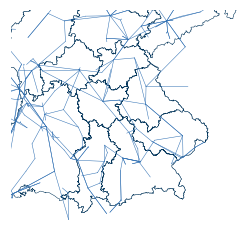

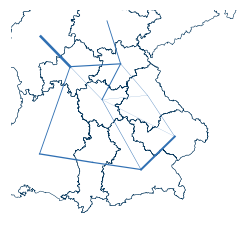

In [17]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
%matplotlib inline

# Read in shape of Germany from GADM data
tra_subfolder_shapes = 'Shapes'
tra_subfolder_vis = 'Visualization'
tra_file_shape_ger = 'DEU_adm1.shp'
tra_file_shape_by = 'bayern.shp'
tra_path_shape_ger = os.path.join(folder_in, tra_subfolder_vis, 
                                  tra_subfolder_shapes, tra_file_shape_ger)
tra_path_shape_by = os.path.join(folder_in, tra_subfolder_vis, 
                                  tra_subfolder_shapes, tra_file_shape_by)
tra_shape_ger = list(shpreader.Reader(tra_path_shape_ger).geometries())
tra_shape_by = list(shpreader.Reader(tra_path_shape_by).geometries())

# Import colors
tumdarkblue = define.tumdarkblue
tumblue = define.tumblue
tumwhite = define.tumwhite

# Define output
data_typ_png = '.png'
tra_file_out_plot_raw = 'bavarian-lines-raw'
tra_path_out_plot_raw = os.path.join(folder_out, tra_subfolder_vis, tra_file_out_plot_raw+dt_png)
tra_file_out_plot_agg = 'bavarian-lines-aggregated'
tra_path_out_plot_agg = os.path.join(folder_out, tra_subfolder_vis, tra_file_out_plot_agg+dt_png)

# Create figure for raw transmission lines plot
tra_fig_raw = plt.figure()

# Generate shape of Bavaria with states
ax = plt.axes(projection=ccrs.EuroPP(), frameon=False)
ax.add_geometries(tra_shape_ger, ccrs.PlateCarree(),
              edgecolor=tumdarkblue, facecolor=tumwhite, linewidth=.5)
ax.add_geometries(tra_shape_by, ccrs.PlateCarree(),
              edgecolor=tumdarkblue, facecolor=tumwhite, linewidth=.5)
ax.set_extent([8.2, 14.5, 47, 51], ccrs.PlateCarree())

# Add all lines to plot
for (lv, lv1, lv2) in tra_links.index.get_values():        
    try:
        plt.plot([tra_nodes.loc[lv1].lon, tra_nodes.loc[lv2].lon], 
                 [tra_nodes.loc[lv1].lat, tra_nodes.loc[lv2].lat],
                 color=tumblue, transform=ccrs.Geodetic(), linewidth=.5)
    except:
        pass
    
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)

# Save plot to file
plt.gcf().savefig(tra_path_out_plot_raw, bbox_inches='tight', dpi=600)

# Create figure for aggregated transmission lines plot
tra_fig_agg = plt.figure()

# Generate shape of Bavaria with states
ax = plt.axes(projection=ccrs.EuroPP(), frameon=False)
ax.add_geometries(tra_shape_ger, ccrs.PlateCarree(),
              edgecolor=tumdarkblue, facecolor=tumwhite, linewidth=.5)
ax.add_geometries(tra_shape_by, ccrs.PlateCarree(),
              edgecolor=tumdarkblue, facecolor=tumwhite, linewidth=.5)
ax.set_extent([8.2, 14.5, 47, 51], ccrs.PlateCarree())

# Read in coordinates of the geographical center of each region/state
tra_coordinates_en = define.coordinates_regions_states_by_en

# Add aggregated lines weighted with capacity to plot
for lv in tra_regionlinks[['vin', 'vout']].itertuples():
    # Weighting line with capacity
    plt.plot([tra_coordinates_en[lv.vin][1], tra_coordinates_en[lv.vout][1]], 
                     [tra_coordinates_en[lv.vin][0], tra_coordinates_en[lv.vout][0]],
                     color=tumblue, transform=ccrs.Geodetic(), 
                     linewidth=tra_regionlinks.loc[lv[0],'cap']/2500)

ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)

# Save plot to file
plt.gcf().savefig(tra_path_out_plot_agg, bbox_inches='tight', dpi=600)

***
***

## Timeseries <a id='timeseries'></a> 
Back to [beginning](#start).

***

### Demand Timeseries Generation<a id='demand'></a> 
Back to [beginning](#start).

In this part the Bavarian demand timeseries is generated out of the load timeseries from the [Open Power System Data Platform](https://data.open-power-system-data.org/time_series/) (primary data from various sources, for a complete list see URL). Their load timeseries is extracted from the ENTSO-E Transparency Platform. Also some data from the [Energieatlas Bayern](https://www.energieatlas.bayern.de/) (Bavarian Ministry for economics) \[License: [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)\] is included in the generating process.


#### Input

Input sources are defined and data is read in. In `dem_ls_amp` and `dem_load_ten` the load of each TSO is saved. In `dem_ls` the weighted load of Bavaria is saved. In `dem_load_regions` the production of power plants in Bavaria separated by each regions is saved.

In [44]:
# Year of demand
dem_year = '2015'

# Define input
dem_file_in_OPSD = 'OPSD-DE-2015-time_series_60min_all'
dem_file_in_EAB = 'Wasserkraft - Gesamtstromverbrauch RB Bayern 2015'
dem_path_in_OPSD = os.path.join(folder_in, ts_subfolder,  dem_file_in_OPSD+dt_csv)
dem_path_in_EAB = os.path.join(folder_in, ts_subfolder, dem_file_in_EAB+dt_csv)


In [45]:
# Load timeseries for Amprion region
# Used columns for dem_ls_amp:
# 0: utc_timestamp - timestep
# 6: DE_amprion_load_new - load of Amprion region
dem_ls_amp = pd.read_csv(dem_path_in_OPSD, sep=',', usecols=[0,6], index_col=0,
                             parse_dates=[0], decimal='.', names=['Time', 'load'],
                             skiprows=1)

# Load timeseries for Tennet region
# Used columns for dem_ls_ten:
# 0: utc_timestamp - timestep
# 7: DE_tennet_load_new - load of TenneT region
dem_ls_ten = pd.read_csv(dem_path_in_OPSD, sep=',', usecols=[0,7], index_col=0,
                             parse_dates=[0], decimal='.', names=['Time', 'load'],
                             skiprows=1)

# Load timeseries for Bavaria
dem_ls = 0.15*dem_ls_amp + 0.85*dem_ls_ten

# Demand for each region
# Used columns for dem_load_regions:
# 0: RB - region
# 5: load - load per region
dem_load_regions = pd.read_csv(dem_path_in_EAB, usecols=[0,5], names=['RB', 'load'], 
                               sep=',', index_col=0, skiprows=1)
dem_load_regions = dem_load_regions.T
dem_load_regions.head()

RB,Oberbayern,Niederbayern,Oberpfalz,Oberfranken,Mittelfranken,Unterfranken,Schwaben
load,27483776.0,8165574.0,6318476.0,5730569.0,8684843.0,7550123.0,11584423.0


#### Calculation

With the loadsum of each region, a factor for transmission losses and the adapted TSO-loadseries, the load for each region per hour is calculated. The quotient of the loadsum of a region and the sum of the loadseries of Bavaria should give a factor for the part each region has on the total load.

<center>$(load\ of\ TSOs) * (\frac{load\ of\ region\ over\ one\ year}{load\ of\ TSOs\ over\ one\ year}) \cdot (factor\ for\ losses) $<center>

In [47]:
# Creating load dataframe
dem_ts_load = pd.DataFrame()

# Factor for production and transmission losses
factor = 0.95

for lv in dem_load_regions:
        # Calculate load series for each region
        help_df = dem_ls.load*(dem_load_regions[lv].values[0]/dem_ls.load.sum())*factor
        help_df = help_df.rename(lv)
        
        dem_ts_load = pd.concat([dem_ts_load,help_df], axis=1, sort=True)

# Translate regions and add .Elec to state name 
dem_ts_load = dem_ts_load.rename(columns=region_translation)
dem_ts_load = dem_ts_load.add_suffix('.Elec')

# Create rows of zeros to adjust output to the input file of urbs
t = pd.Timestamp('2000-01-01 00:00:00')
zero_row = pd.DataFrame({'Time': [t]})

for lv in dem_load_regions:
    zero_row.insert(+1,column=lv,value=0)
    
zero_row = zero_row.rename(columns=region_translation)
zero_row.set_index(['Time'], inplace=True)
zero_row = zero_row.add_suffix('.Elec')

# Adding row of zeros
dem_ts_load = pd.concat([dem_ts_load, zero_row], sort=True)

# Rename columns to english region names
dem_ts_load = dem_ts_load.rename(columns=region_translation)

dem_ts_load = dem_ts_load.sort_index()
dem_ts_load.head()

,Lower Bavaria.Elec,Lower Franconia.Elec,Middle Franconia.Elec,Swabia.Elec,Upper Bavaria.Elec,Upper Franconia.Elec,Upper Palatinate.Elec
Time,,,,,,,
2000-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-01 00:00:00,672.441470,621.758594,715.203682,953.986386,2263.310666,471.916884,520.331490
2015-01-01 01:00:00,643.260735,594.777253,684.167273,912.587952,2165.093839,451.437955,497.751599
2015-01-01 02:00:00,618.670257,572.040194,658.013025,877.701672,2082.326944,434.180450,478.723623
2015-01-01 03:00:00,603.922417,558.403920,642.327334,856.779051,2032.688508,423.830472,467.311826


#### Output


In [48]:
# Define output
dem_file_out = 'Bavarian Electricity Demand Timeseries with factor '+dem_year
dem_path_out = os.path.join(folder_out, ts_subfolder, dem_file_out+dt_xlsx)

# Save data to excel file
dem_ts_load.to_excel(dem_path_out)

***

### Supply Intermittent Timeseries Generation<a id='supim'></a> 
Back to [beginning](#start).

In this part the supply intermittent timeseries is created. 

Firstly, the solar and wind timeseries for Bavaria is generated with data from [Renewables.ninja](https://www.renewables.ninja/) \[License: [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)\]. To access the database, an account and by this a token has to be created on their homepage. The tokan has to be included at `sup_sw_token`.

Secondly, the Bavarian hydro timeseries is generated with data from [Gewässerkundlicher Dienst Bayern](http://www.gkd.bayern.de/fluesse/abfluss/karten/index.php?thema=gkd&rubrik=fluesse&produkt=wasserstand&gknr=0&sp=en) \[License: [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)\]. Also data from [Energieatlas Bayern](https://www.energieatlas.bayern.de/) (Bavarian Ministry for economics) \[License: [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)\] is used.

In [186]:
import requests

#### Input
Information, which are necessary for the request, are defined.

In [199]:
# Year of data
sup_year = '2015'

# Data to access Renewables.ninja
sup_solar_url = 'https://www.renewables.ninja/api/data/pv'
sup_wind_url = 'https://www.renewables.ninja/api/data/wind'
sup_sw_token = '' #Insert your token here
sup_sw_req = requests.session()
sup_sw_req.headers = {'Authorization': 'Token ' + sup_sw_token}


# Define input for hydro data
sup_hydro_subfolder = 'Hydro'
sup_hydro_file_in_prod = 'Wasserkraft - Gesamtstromverbrauch RB Bayern '+sup_year
sup_hydro_file_in_cap = 'Wasserkraft - Installierte Leistung RB Bayern '+sup_year
sup_hydro_path_in_prod = os.path.join(folder_in, ts_subfolder, 
                                      sup_hydro_file_in_prod+dt_csv)
sup_hydro_path_in_cap = os.path.join(folder_in, ts_subfolder,
                                      sup_hydro_file_in_cap+dt_csv)

# Import list of coordinates for each state
sup_sw_coord = define.coordinates_regions_by_en

# Import azimus
sup_sw_azimuth = define.azimuth

# Import list of cities for each region
sup_cities = define.region_cities

# Import dict to translate column names
sup_hydro_col_dict = define.hydro_columns_translate

# Import dict to assign cities to regions
sup_city_to_regions = define.city_to_region_en

#### Solar and Wind Timeseries - Request
For each definded point a request is send to [Renewables.ninja](https://www.renewables.ninja/). In response solar and wind timeseries will be gained. As after each request a break of 15 seconds is made, this cell needs some time to execute.

In [236]:
sup_sw_ts = pd.DataFrame()

for lv in sup_sw_coord.keys():
### Solar data
    help_solar = pd.DataFrame()
    
    # Request data for every orientation
    for az in sup_sw_azimuth.keys():
        # Get data for defined coordinates for each state
        args = {'lat': sup_sw_coord[lv][0], 'lon': sup_sw_coord[lv][1], 
                'date_from': sup_year+'-01-01', 'date_to': sup_year+'-12-31', 'dataset': 'merra2', 
                'capacity': 1.0, 'system_loss': 0, 'tracking': 0, 'tilt': 35, 
                'azim': sup_sw_azimuth[az], 'format': 'json', 'metadata': False, 'raw':False}
        help_data = sup_sw_req.get(sup_solar_url, params=args)
        help_df = pd.read_json(help_data.text, orient='index')
        
        # Adapt recieved data
        help_df = help_df.rename(columns={'output': lv+'.Solar.'+az})
        help_df.index.names = ['Time']
        help_solar = pd.concat([help_solar, help_df], axis=1)
        
        # Add delay to overcome 6 requests/min limit of server
        time.sleep(15)
    
    # Weighted solar timeseries
    help_solar[lv+'.Solar'] = (0.15*help_solar[lv+'.Solar.East'] +
                              0.7*help_solar[lv+'.Solar.South'] +
                              0.15*help_solar[lv+'.Solar.West'])
    sup_sw_ts = pd.concat([sup_sw_ts, help_solar[lv+'.Solar']], axis=1)
    
### Wind data
    # Get data for defined coordinates for each state
    args = {'lat': sup_sw_coord[lv][0], 'lon': sup_sw_coord[lv][1], 
            'date_from': sup_year+'-01-01', 'date_to': sup_year+'-12-31', 
            'capacity': 1.0, 'height': 100, 'turbine': 'Vestas V90 2000', 
            'format': 'json', 'metadata': False, 'raw':False}
    help_data = sup_sw_req.get(sup_wind_url, params=args)
    help_df = pd.read_json(help_data.text, orient='index')
    
    # Adapt recieved data
    help_df = help_df.rename(columns={'output': lv+'.Wind'})
    help_df.index.names = ['Time']
    help_df = help_df*0.65
    sup_sw_ts = pd.concat([sup_sw_ts, help_df], axis=1)
    
    # Add delay to overcome 6 requests/min limit of server
    time.sleep(15)
    
# Define output
sup_file_sw_ts_out = 'solar_and_wind_ts'
sup_path_sw_ts_out = os.path.join(folder_out, ts_subfolder, 
                            sup_file_sw_ts_out+dt_xlsx)

# Save data to excel file
sup_sw_ts.to_excel(sup_path_sw_ts_out)

sup_sw_ts.head()

,Upper Bavaria.Solar,Upper Bavaria.Wind,Lower Bavaria.Solar,Lower Bavaria.Wind,Upper Palatinate.Solar,Upper Palatinate.Wind,Upper Franconia.Solar,Upper Franconia.Wind,Middle Franconia.Solar,Middle Franconia.Wind,Lower Franconia.Solar,Lower Franconia.Wind,Swabia.Solar,Swabia.Wind
Time,,,,,,,,,,,,,,
2015-01-01 00:00:00,0.0,0.12155,0.0,0.10530,0.0,0.07280,0.0,0.04420,0.0,0.06045,0.0,0.03900,0.0,0.02795
2015-01-01 01:00:00,0.0,0.11960,0.0,0.09685,0.0,0.06890,0.0,0.04290,0.0,0.05850,0.0,0.04095,0.0,0.02275
2015-01-01 02:00:00,0.0,0.11895,0.0,0.09165,0.0,0.06760,0.0,0.04550,0.0,0.06045,0.0,0.04550,0.0,0.01755
2015-01-01 03:00:00,0.0,0.12415,0.0,0.09165,0.0,0.06760,0.0,0.04810,0.0,0.06175,0.0,0.04485,0.0,0.01430
2015-01-01 04:00:00,0.0,0.11960,0.0,0.08970,0.0,0.06565,0.0,0.04615,0.0,0.05785,0.0,0.04095,0.0,0.01105


#### Hydro Timeseries - Normalizing and Calculation

In the following data for annual production and capacity of hydro power plants in each state are read in. The normalizing of the hydro power plants is created. For each timestep a value is calculated by multipling the normalized value with the annual production and the inverse capacity. By this, the percentage of the maximaum production is gained. As a lot of data is read in, this cell also will take some time to execute.

In [218]:
# Create new dataframe 
sup_hydro_levels = pd.DataFrame()

# Merge all water levels in one dataframe
for lv in range(0,len(sup_cities)):
    # Read in data
    help_file = 'WS '+sup_cities[lv]
    help_path = os.path.join(folder_in, ts_subfolder, sup_hydro_subfolder,
                             help_file+dt_csv)
    # Used columns:
    # 0: Datum - timestep
    # 1: Wasserstand - water level
    help_df = pd.read_csv(help_path, sep=';', skiprows=11, names=['Time',sup_cities[lv]],
                          index_col=0, usecols=[0,1], parse_dates=[0],
                          decimal=',')
    help_df = help_df[sup_year]
    
    # Collect data hourly
    help_df = help_df.resample('1H').mean()
   
    sup_hydro_levels = pd.concat([sup_hydro_levels, help_df], axis=1)

# Rename waterlevels to region names and sort them 
sup_hydro_levels.rename(columns=sup_city_to_regions, inplace=True)
sup_hydro_levels = sup_hydro_levels.sort_index(axis=1)

# Delete duplicate entries
sup_hydro_levels.drop_duplicates(keep='first', inplace=True)

# create copy instead of pointer
sup_hydro_bounded = sup_hydro_levels.copy(deep=True)
        
# Bound jumps
negative_slope = 0.5
positive_slope = 0.05

lower = sup_hydro_bounded.diff().min()*negative_slope
upper = sup_hydro_bounded.diff().max()*positive_slope

for hydro_index in range(1,sup_hydro_bounded.index.size):
    help_diff = sup_hydro_bounded.iloc[hydro_index] - sup_hydro_bounded.iloc[hydro_index-1]
    if (help_diff > upper).any():
        sup_hydro_bounded.iloc[hydro_index].loc[(help_diff > upper)] = \
        sup_hydro_bounded.iloc[hydro_index-1].loc[(help_diff > upper)] + upper.loc[(help_diff > upper)]
    if (help_diff < lower).any():
        sup_hydro_bounded.iloc[hydro_index].loc[(help_diff < lower)] = \
        sup_hydro_bounded.iloc[hydro_index-1].loc[(help_diff < lower)] + lower.loc[(help_diff < lower)]

# Read in data for hydro production
sup_hydro_prod = pd.read_csv(sup_hydro_path_in_prod, sep=',', index_col=0)
sup_hydro_prod.rename(columns=sup_hydro_col_dict, inplace=True)

# Read in data for hydro capacity
sup_hydro_cap = pd.read_csv(sup_hydro_path_in_cap, sep=',', index_col=0)
sup_hydro_cap.rename(columns=sup_hydro_col_dict, inplace=True)

# Calculate full-load-hours
flh = sup_hydro_prod.wpercent/100*sup_hydro_prod.energy/sup_hydro_cap.cap
flh.rename(index=region_translation, inplace=True)

# Define tangens hyperbolicus parameters
tanh_slope = 2.4
tanh_xshift = 1.5
# squeeze tanh spectrum from [-1,1] to [-0.5, 0.5]
tanh_squeeze = 0.5
# shift tanh spectrum from [-0.5, 0.5] to [0, 1]
tanh_yshift=0.5

# Transform to time series between [0, 1] while weighting waterlevels with flh
transformed = np.tanh(sup_hydro_bounded/(sup_hydro_bounded.sum())*
                      flh*tanh_slope-tanh_xshift)*tanh_squeeze+tanh_yshift
# Clip still needed for Saarland as flh are above 8760
sup_hydro_timeseries = (transformed/transformed.sum()*flh).clip(0,1)

# Fill time series of not existing production
sup_hydro_timeseries = sup_hydro_timeseries.fillna(0)

sup_hydro_ts = sup_hydro_timeseries.add_suffix('.Hydro')

# Define output
sup_file_hydro_ts_out = 'hydro_ts'
sup_path_hydro_ts_out = os.path.join(folder_out, ts_subfolder, 
                            sup_file_hydro_ts_out+dt_xlsx)

# Save data to excel file
sup_hydro_ts.to_excel(sup_path_hydro_ts_out)

sup_hydro_ts.head()

,Lower Bavaria.Hydro,Lower Franconia.Hydro,Middle Franconia.Hydro,Swabia.Hydro,Upper Bavaria.Hydro,Upper Franconia.Hydro,Upper Palatinate.Hydro
Time,,,,,,,
2015-01-01 00:00:00,0.488177,0.773044,0.328385,0.318745,0.315805,0.467893,0.458600
2015-01-01 01:00:00,0.490687,0.782582,0.328385,0.315210,0.313531,0.473082,0.456833
2015-01-01 02:00:00,0.492703,0.797337,0.328385,0.313453,0.319008,0.478301,0.456833
2015-01-01 03:00:00,0.491343,0.797337,0.328385,0.320790,0.311945,0.483548,0.455069
2015-01-01 04:00:00,0.488629,0.793342,0.328385,0.328243,0.315577,0.488824,0.454482


#### Adaption
For better adaption to the input file of urbs, a row of zeros is added to the first row of the dataframes and they are sorted. Finally, they are collected in one dataframe.

If solar and wind or hydro time series already exist, they can be read in in the following cell. Otherwise, this cell can be skipped. 

In [244]:
# Try to read in solar and wind or hydro timeseries
try:
    sup_file_sw_ts_in = 'solar_and_wind_ts'
    sup_path_sw_ts_in = os.path.join(folder_out, ts_subfolder, 
                            sup_file_sw_ts_in+dt_xlsx)
    sup_sw_ts = pd.read_excel(sup_path_sw_ts_in, index_col=0)
except:
    print('Solar and wind time series does not exist. Please run the cell above!')
    
try:
    sup_file_hydro_ts_in = 'hydro_ts'
    sup_path_hydro_ts_in = os.path.join(folder_out, ts_subfolder, 
                            sup_file_hydro_ts_in+dt_xlsx)
    sup_hydro_ts = pd.read_excel(sup_path_hydro_ts_in, index_col=0)
except:
    print('Hydro time series does not exist. Please run the cell above!')

In [251]:
# Create timestemp for first row
t = pd.Timestamp('2000-01-01 00:00:00')

# Creating list of states with ending .Solar and .Wind
sup_regions_sw = []
for rg in regions_en:
    sup_regions_sw.append(rg+'.Solar')
    sup_regions_sw.append(rg+'.Wind')

# Adding row of zero to solar and wind timeseries
zero_row = pd.DataFrame({'Time': [t]})
for rg in sup_regions_sw:
    zero_row.insert(+1,column=rg,value=0)
zero_row.set_index(['Time'], inplace=True)
zero_row.sort_index(axis=1)
sup_sw_ts = pd.concat([sup_sw_ts, zero_row], sort=True)
sup_sw_ts.sort_index(inplace=True)

# Creating list of states with ending .Hydro
sup_regions_hydro =[]
for rg in regions_en:
    sup_regions_hydro.append(rg+'.Hydro')

# Adding row of zero to hydro timeseries
zero_row = pd.DataFrame({'Time': [t]})
for rg in sup_regions_hydro:
    zero_row.insert(+1,column=rg,value=0)
zero_row.set_index(['Time'], inplace=True)
zero_row.sort_index(axis=1)
sup_hydro = pd.concat([sup_hydro_ts, zero_row], sort=True)
sup_hydro.sort_index(inplace=True)

# Adapting dataframes
sup_sw_ts.reset_index(inplace=True)
sup_sw_ts.drop('Time', axis=1, inplace=True)
sup_hydro.reset_index(inplace=True)
sup_hydro.drop('Time', axis=1, inplace=True)

# Concatenate dataframes
sup_ts = pd.concat([sup_sw_ts, sup_hydro], axis=1, sort=True)

sup_ts = sup_ts.sort_index(axis=1)
sup_ts.head()

,Lower Bavaria.Hydro,Lower Bavaria.Solar,Lower Bavaria.Wind,Lower Franconia.Hydro,Lower Franconia.Solar,Lower Franconia.Wind,Middle Franconia.Hydro,Middle Franconia.Solar,Middle Franconia.Wind,Swabia.Hydro,...,Swabia.Wind,Upper Bavaria.Hydro,Upper Bavaria.Solar,Upper Bavaria.Wind,Upper Franconia.Hydro,Upper Franconia.Solar,Upper Franconia.Wind,Upper Palatinate.Hydro,Upper Palatinate.Solar,Upper Palatinate.Wind
0,0.000000,0.0,0.00000,0.000000,0.0,0.00000,0.000000,0.0,0.00000,0.000000,...,0.00000,0.000000,0.0,0.00000,0.000000,0.0,0.0000,0.000000,0.0,0.0000
1,0.488177,0.0,0.00000,0.773044,0.0,0.00000,0.328385,0.0,0.00000,0.318745,...,0.00000,0.315805,0.0,0.00000,0.467893,0.0,0.0000,0.458600,0.0,0.0000
2,0.490687,0.0,0.10530,0.782582,0.0,0.03900,0.328385,0.0,0.06045,0.315210,...,0.02795,0.313531,0.0,0.12155,0.473082,0.0,0.0442,0.456833,0.0,0.0728
3,0.492703,0.0,0.09685,0.797337,0.0,0.04095,0.328385,0.0,0.05850,0.313453,...,0.02275,0.319008,0.0,0.11960,0.478301,0.0,0.0429,0.456833,0.0,0.0689
4,0.491343,0.0,0.09165,0.797337,0.0,0.04550,0.328385,0.0,0.06045,0.320790,...,0.01755,0.311945,0.0,0.11895,0.483548,0.0,0.0455,0.455069,0.0,0.0676


#### Output

In [252]:
# Define output
sup_file_out = 'Bavarian Supply Intermittent Timeseries'
sup_path_out = os.path.join(folder_out, ts_subfolder, 
                            sup_file_out+dt_xlsx)

# Save data to excel file
sup_ts.to_excel(sup_path_out)

#### Plot

In [232]:
start_time = '2015-07-06 00:00:00'
end_time = '2015-07-12 23:00:00'

colors = [define.tumgreen, define.tumblue, define.tumdarkerblue, define.tumdarkblue,
          define.tumlightblue, define.tumlighterblue, define.tumorange, define.tumivory,
          define.tumblack, define.tumgrey, define.tumlightgrey, define.tumviolet,
          define.tumturquois, define.tumdarkgreen, define.tumred, define.tumbrightyellow,
          define.tumsenf, define.tumbrown, define.tumdarkgrey]

vis_hydro_states= ['Lower Bavaria', 'Lower Franconia', 'Middle Franconia', 'Swabia',
                   'Upper Bavaria', 'Upper Franconia', 'Upper Palatinate']

# Read in hydro timeseries
vis_hydro_file_in = 'hydro_ts'
vis_hydro_path_in = os.path.join(folder_out, ts_subfolder, vis_hydro_file_in+dt_xlsx)
vis_hydro_ts = pd.read_excel(vis_hydro_path_in, index_col=0)

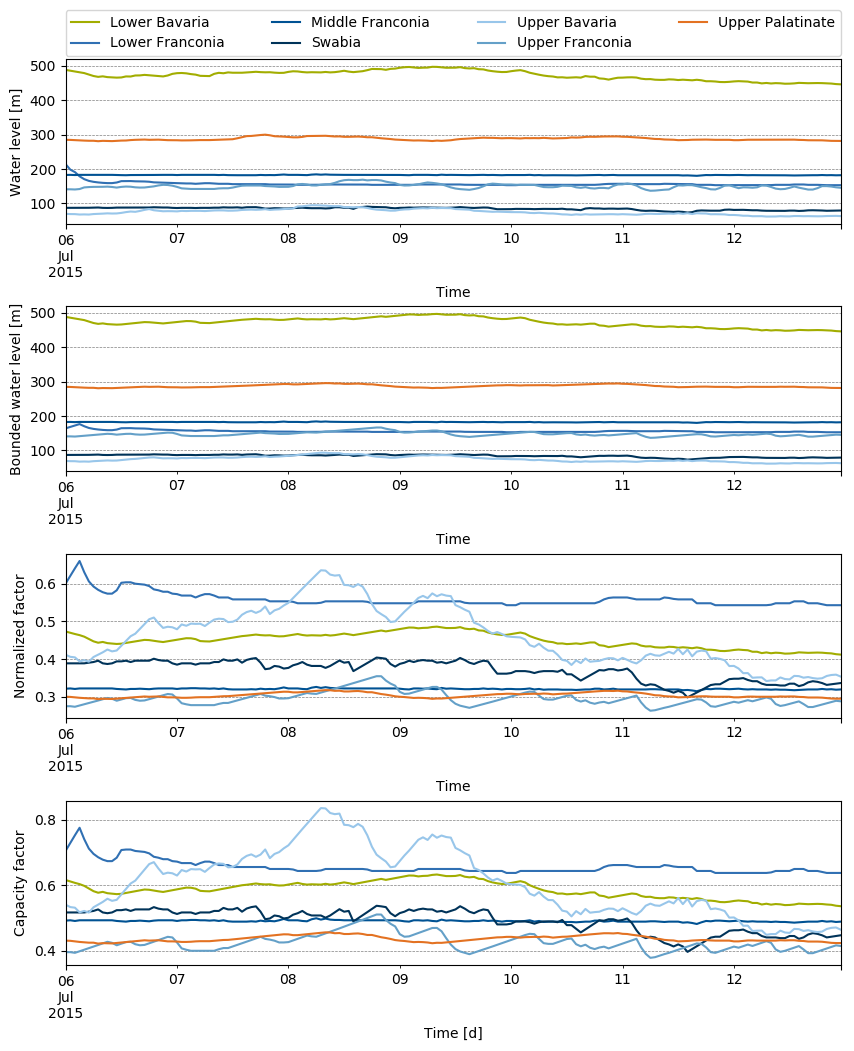

In [233]:
# Plot comparison in one figure
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,12), dpi=100)

# Set space between subplots
fig.subplots_adjust(hspace = 0.5) 

# Create dataframe for plotting
vis_hydro = pd.DataFrame()
for state in vis_hydro_states:
    vis_hydro = pd.concat([vis_hydro, sup_hydro_levels[state].loc[start_time:end_time]], axis=1, sort=True)
vis_hydro.columns = vis_hydro_states
vis_hydro = vis_hydro.sort_index(axis=1)

# Plot orignal
ax1 = vis_hydro.plot(color=colors,ax=axes[0])


# Create dataframe for plotting
vis_hydro = pd.DataFrame()
for state in vis_hydro_states:
    vis_hydro = pd.concat([vis_hydro, sup_hydro_bounded[state].loc[start_time:end_time]], axis=1, sort=True)
vis_hydro.columns = vis_hydro_states
vis_hydro = vis_hydro.sort_index(axis=1)

# Plot bounded
ax2 = vis_hydro.plot(color=colors,ax=axes[1], legend=False)


# Create dataframe for plotting
vis_hydro = pd.DataFrame()
for state in vis_hydro_states:
    vis_hydro = pd.concat([vis_hydro, transformed[state].loc[start_time:end_time]], axis=1, sort=True)
vis_hydro.columns = vis_hydro_states
vis_hydro = vis_hydro.sort_index(axis=1)

# Plot tangens
ax3 = vis_hydro.plot(color=colors,ax=axes[2], legend=False)


# Create dataframe for plotting
vis_hydro = pd.DataFrame()
for state in vis_hydro_states:
    vis_hydro = pd.concat([vis_hydro, vis_hydro_ts[state+'.Hydro'].loc[start_time:end_time]], axis=1, sort=True)
vis_hydro.columns = vis_hydro_states
vis_hydro = vis_hydro.sort_index(axis=1)

# Plot bounded
ax4 = vis_hydro.plot(color=colors,ax=axes[3], legend=False)

# Add legend
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", borderaxespad=0.)
ax4.set_xlabel('Time [d]')
# Labels
ax1.set_ylabel('Water level [m]')
ax2.set_ylabel('Bounded water level [m]')
ax3.set_ylabel('Normalized factor')
ax4.set_ylabel('Capacity factor')
#ax1.set_ylim([0,1]) # Adapt the numbers to plot if necessary!
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim([start_time,end_time])
    ax.grid(color='grey', linestyle='--', linewidth=.5)

# Define output and save file
comp_file_out = 'hydro-development'
comp_path_out = os.path.join(folder_out, 'Visualization', comp_file_out+dt_png)
plt.gcf().savefig(comp_path_out, bbox_inches='tight', dpi=600)